## Surfs up! Data analysis


In [3]:
# Step 1 - Climate Analysis and Exploration

# Precipitation Analysis

# Dependencies declaration 
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import create_engine, MetaData, Table, Column, ForeignKey
from sqlalchemy.ext.automap import automap_base
from flask import Flask, jsonify

In [4]:
# Use SQLAlchemy create_engine to connect to your sqlite database.
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Collect the names of tables within the database
inspector = inspect(engine)
engine.table_names()
print(engine.table_names())

['measurement', 'station']


In [6]:
columns = inspector.get_columns('measurement')
print(f'Columns in measurement table:')
for c in columns:
    print(c['name'], c["type"])
    
columns = inspector.get_columns('station')
print(f'Columns in station table:')
for c in columns:
    print(c['name'], c["type"])

Columns in measurement table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
Columns in station table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

session = Session(engine)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Precipitation Analysis

# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).scalar()
last_date

date_time_obj = dt.datetime.strptime(last_date, '%Y-%m-%d')
year = dt.timedelta(days=365)
last_date_last_year = date_time_obj - year

precipitation = session.query(Measurement.date, Measurement.prcp)\
.filter(Measurement.date >= last_date_last_year).order_by(Measurement.date).all()

In [9]:
print('Last date detected on data:', date_time_obj)
print('Last date from previous year on data:', last_date_last_year)

Last date detected on data: 2017-08-23 00:00:00
Last date from previous year on data: 2016-08-23 00:00:00


In [10]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
# Sort the DataFrame values by date.
df = pd.DataFrame(precipitation)
df.columns = precipitation[0].keys()
df.set_index("date").fillna(0).head(10)

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,0.00
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


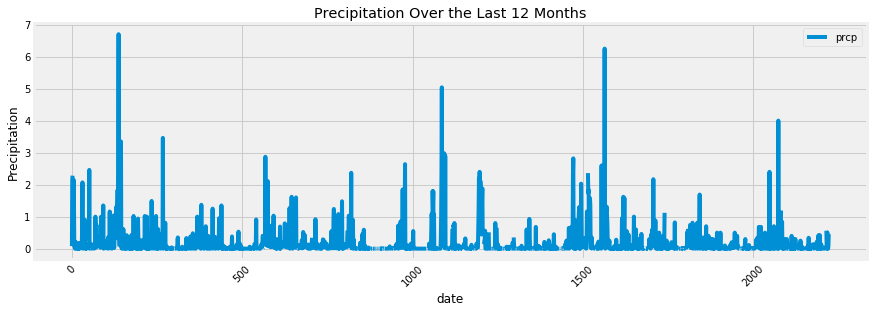

In [11]:
# Plot the results using the DataFrame plot method.
df.plot(figsize=(12, 4), x_compat=True)
#set the title
plt.title('Precipitation Over the Last 12 Months')
plt.tight_layout()
plt.xlabel("date")    
plt.ylabel("Precipitation")     
#rotate the x labels 45 degrees
plt.xticks(rotation=45)
#make it a tight layout
plt.show()

In [12]:
# Use Pandas to print the summary statistics for the precipitation data.
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Station Analysis

# Design a query to calculate the total number of stations.
station_number = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).all()
print('TOTAL AMOUNT OF STATIONS DETECTED IN DATASET:', len(station_number))

TOTAL AMOUNT OF STATIONS DETECTED IN DATASET: 9


In [14]:
# Design a query to find the most active stations.
most_active = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

# Which station has the highest number of observations?
print(f'MOST ACTIVE STATION DETECTED IS: \n STATION {most_active[0][0]} WITH {most_active[0][1]} TOBS OCURRENCES.\n')

i = 1
for row, ocurrences in most_active:
#     print(row, ocurrences)
    print(f'THE TOP {i} STATION DETECTED IS:\n STATION {row} WITH {ocurrences} TOBS OCURRENCES.\n')
    i += 1

MOST ACTIVE STATION DETECTED IS: 
 STATION USC00519281 WITH 2772 TOBS OCURRENCES.

THE TOP 1 STATION DETECTED IS:
 STATION USC00519281 WITH 2772 TOBS OCURRENCES.

THE TOP 2 STATION DETECTED IS:
 STATION USC00519397 WITH 2724 TOBS OCURRENCES.

THE TOP 3 STATION DETECTED IS:
 STATION USC00513117 WITH 2709 TOBS OCURRENCES.

THE TOP 4 STATION DETECTED IS:
 STATION USC00519523 WITH 2669 TOBS OCURRENCES.

THE TOP 5 STATION DETECTED IS:
 STATION USC00516128 WITH 2612 TOBS OCURRENCES.

THE TOP 6 STATION DETECTED IS:
 STATION USC00514830 WITH 2202 TOBS OCURRENCES.

THE TOP 7 STATION DETECTED IS:
 STATION USC00511918 WITH 1979 TOBS OCURRENCES.

THE TOP 8 STATION DETECTED IS:
 STATION USC00517948 WITH 1372 TOBS OCURRENCES.

THE TOP 9 STATION DETECTED IS:
 STATION USC00518838 WITH 511 TOBS OCURRENCES.



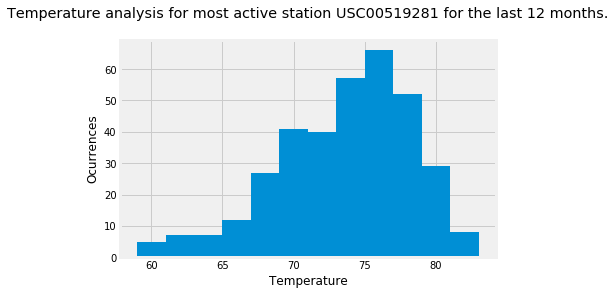

In [15]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
tobs_data = session.query(Measurement.station, Measurement.date, Measurement.prcp, \
                          Measurement.tobs).filter(Measurement.station == 'USC00519281')\
                        .filter(Measurement.date >= last_date_last_year).order_by(Measurement.date).all()

# Plot the results as a histogram with bins=12. 
bins_df =pd.DataFrame(tobs_data)
plt.hist(bins_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Ocurrences")
plt.title(f'Temperature analysis for most active station {most_active[0][0]} for the last 12 months.\n')
plt.show()

In [16]:
# Step 2 - Climate App

# Use FLASK to create your routes.
# Flask Setup
app = Flask(__name__)

# Flask Routes
from flask import request

@app.route("/")
def welcome():
    return (
        f"Welcome to the API Home page:<br/>"
        f"Available Routes:<br/>"
#         f"/api/v1.0/justice-league" 
        
        f"--/api/v1.0/precipitation<br/>"
        f"--/api/v1.0/stations<br/>"
        f"--/api/v1.0/tobs<br/>"
        f"--/api/v1.0/<start> <br/>" 
        f"--/api/v1.0/<start>/<end>"
    )

# /api/v1.0/precipitation
# Convert the query results to a Dictionary using date as the key and prcp as the value.
# Return the JSON representation of your dictionary.
@app.route("/api/v1.0/precipitation")
def precipitation():
    # Query all 
    results = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= last_date_last_year).order_by(Measurement.date).all()

    # Create a dictionary from the row data and append to a list of all_precipitations
    all_precipitations = []
    for result in results:
        precipitation_dict = {}
        precipitation_dict["date"] = result.date
        precipitation_dict["prcp"] = result.prcp
        all_precipitations.append(precipitation_dict)

    return jsonify(all_precipitations)

# /api/v1.0/stations
# Return a JSON list of stations from the dataset (and also count of stations).
@app.route("/api/v1.0/stations")
def stations():
    # Query all 
    station_results = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).all()

    # return jsonify(all_stations)
    all_stations = list(np.ravel(station_results))
    return jsonify(all_stations)

# /api/v1.0/tobs
# Query for the dates and temperature observations from a year from the last data point.
# Return a JSON list of Temperature Observations (tobs) for the previous year.
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
tobs_data = session.query(Measurement.station,\
                          Measurement.date,\
                          Measurement.tobs).\
                          filter(Measurement.date >= last_date_last_year).order_by(Measurement.date).all()
    
@app.route("/api/v1.0/tobs")
def tobs():
    # Query all 
    all_tobs = list(np.ravel(tobs_data))
    return jsonify(all_tobs)

# /api/v1.0/<start> and /api/v1.0/<start>/<end>
# Return a JSON list of the minimum temperature, the average temperature, and the max temperature 
# for a given start or start-end range.
# When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal
# to the start date.
@app.route("/api/v1.0/<start>")
def startdata(start):
    start_data = session.query(Measurement.date, func.avg(Measurement.tobs),                                  func.max(Measurement.tobs), func.min(Measurement.tobs)).                            filter(Measurement.date >= start).                            order_by(Measurement.date).all()

#Create JSON
    data_list = []
    for result in start_data:
        row = {}
        row['date'] = result[0]
        row['avg'] = float(result[1])
        row['max'] = float(result[2])
        row['min'] = float(result[3])
        data_list.append(row)

    return jsonify(data_list) 
    
@app.route("/api/v1.0/<start>/<end>")
def startdataend(start, end):
    start_dataend = session.query(Measurement.date, func.avg(Measurement.tobs),                                  func.max(Measurement.tobs), func.min(Measurement.tobs)).                            filter(Measurement.date >= start).filter(Measurement.date <= end).                            order_by(Measurement.date).all()
#Create JSON
    dataend_list = []
    for result in start_dataend:
        row = {}
        row['date'] = result[0]
        row['avg'] = float(result[1])
        row['max'] = float(result[2])
        row['min'] = float(result[3])
        dataend_list.append(row)

    return jsonify(dataend_list) 

if __name__ == "__main__":
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
